# Background Remvoal with SVD

**Our goal today**: ![background removal](images/surveillance3.png)

### Load and Format the Data

Let's use the real video 003 dataset from [BMC 2012 Background Models Challenge Dataset](http://bmc.iut-auvergne.com/?page_id=24)

Import needed libraries:

In [1]:
import imageio
imageio.plugins.ffmpeg.download()

In [2]:
import moviepy.editor as mpe
import numpy as np
import scipy

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
np.set_printoptions(precision=4, suppress=True)

In [4]:
video = mpe.VideoFileClip("movie/Video_003.avi")

In [5]:
video.subclip(0,50).ipython_display(width=300)

100%|█████████████████████████████████████▉| 350/351 [00:00<00:00, 1950.87it/s]


In [6]:
video.duration

113.57

### Helper Methods

In [7]:
def create_data_matrix_from_video(clip, fps=5, scale=50):
    return np.vstack([scipy.misc.imresize(rgb2gray(clip.get_frame(i/float(fps))).astype(int), 
                      scale).flatten() for i in range(fps * int(clip.duration))]).T

In [8]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

### Format the Data

An image from 1 moment in time is 120 pixels by 160 pixels (when scaled). We can *unroll* that picture into a single tall column. So instead of having a 2D picture that is $120 \times 160$, we have a $1 \times 19,200$ column 

This isn't very human-readable, but it's handy because it lets us stack the images from different times on top of one another, to put a video all into 1 matrix.  If we took the video image every hundredth of a second for 100 seconds (so 10,000 different images, each from a different point in time), we'd have a $10,000 \times 19,200$ matrix, representing the video! 

In [9]:
scale = 0.50   # Adjust scale to change resolution of image
dims = (int(240 * scale), int(320 * scale))
fps = 60      # frames per second

In [10]:
M = create_data_matrix_from_video(video.subclip(0,100), fps, scale).T
# M = np.load("movie/med_res_surveillance_matrix_60fps.npy")

In [11]:
print(dims, M.shape)

(120, 160) (6000, 19200)


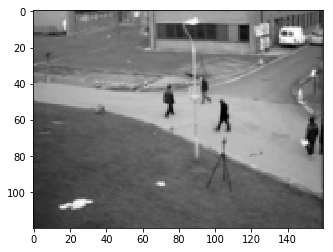

In [12]:
plt.imshow(np.reshape(M[140, :], dims), cmap='gray');

Since `create_data_from_matrix` is somewhat slow, we will save our matrix.  In general, whenever you have slow pre-processing steps, it's a good idea to save the results for future use.

In [13]:
np.save("movie/med_res_surveillance_matrix_60fps.npy", M)

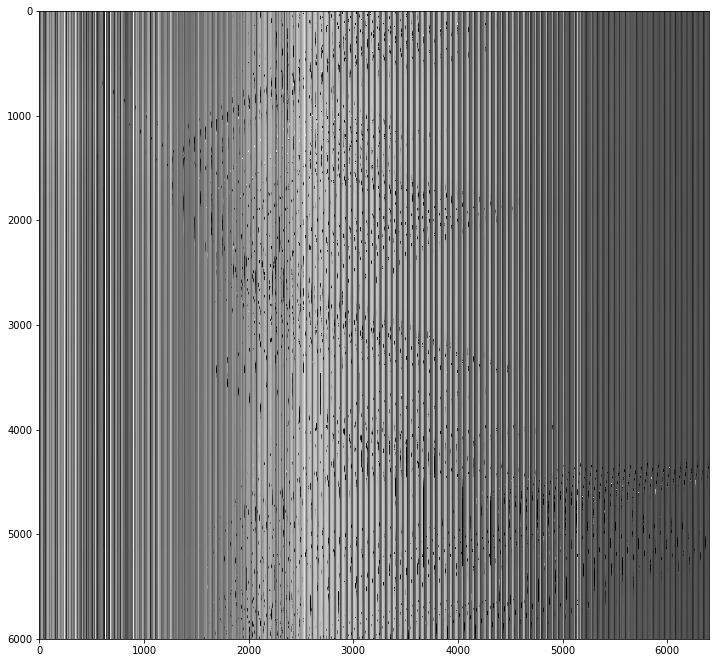

In [14]:
plt.figure(figsize=(12, 12))
plt.imshow(M[:,::3], cmap='gray')

**Questions**: What are those wavy black lines?  What are the horizontal lines?

**Answer**: foreground, background

## Background: Singular Value Decomposition

### Intro to SVD

“a convenient way for breaking a matrix into simpler, meaningful pieces we care about” – [David Austin](http://www.ams.org/samplings/feature-column/fcarc-svd)

“the most important linear algebra concept I don’t remember learning” - [Daniel Lemire](http://lemire.me/blog/2010/07/05/the-five-most-important-algorithms/)

**Applications of SVD**:
- Principal Component Analysis
- Data compression
- Pseudo-inverse
- Collaborative Filtering
- Topic Modeling
- Background Removal
- Removing Corrupted Data

To gain insight into the SVD, treat the rows of an $n \times d$ matrix A as $n$ points in a $d$-dimensional space and consider the problem of finding the best k-dimensional subspace with respect to the set of points. Here best means minimize the sum of the squares of the perpendicular distances of the points to the subspace. Consider projecting a point $\mathbf{x}$ onto a
line through the origin. Then,

$$
x_1^2 + x_2^2 + \dots + x_d^2 = \text{length of projection}^2 + \text{distance of point to line}^2.
$$

<img src="images/svd.jpg" alt="floating point" style="width: 80%"/>

To minimize the sum of the squares of the distances to the line, one could maximize the sum of the squares of the lengths of the projections onto the line.  Similarly for best-fit subspaces, we could maximize the sum of the squared lengths of the projections onto the subspace instead of minimizing the sum of squared distances to the subspace.


### Left Singular Vectors
Let $\mathbf{v}$ be a unit vector along the best fit line through the origin. The length of the projection of $\mathbf{a_i}$, the $i$th row of $A$, onto $\mathbf{v}$ is $|\mathbf{a_i} \cdot \mathbf{v}|$. From this we see that the sum of length squared of the projections is $|A \mathbf{v}|^2$. The best fit line is the one maximizing $|A \mathbf{v}|^2$ and hence minimizing the sum of the squared distances of the points to the line.

With this in mind, define the first singular vector, $\mathbf{v_1}$, of $A$, which is a column vector, as the best fit line through the origin for the $n$ points in $d$-space that are the rows of A. Thus,

$$
\mathbf{v_1} = arg max_{|\mathbf{v}|=1} |A \mathbf{v}|
$$

The value $\sigma_1 (A) = |A \mathbf{v_1}|$ is called the *first singular value* of A. Note that $\sigma_1^2$ is the sum of the squares of the projections of the points to the line determined by $\mathbf{v_1}$.

The *second signular vector*, $\mathbf{v_2}$, is defined by the best fit line perpendicular to $\mathbf{v_1}$

$$
\mathbf{v_2} = arg max_{\mathbf{v} \perp \mathbf{v_1}, |\mathbf{v}|=1} |A\mathbf{v}|
$$

The value $\sigma_2(A) = |A \mathbf{v_2}|$ is called the *second sigular value* of A. The rest of sigular values are defined in a similar manner. The process stops until we found a 0 sigular value.

*Note the sum of squares of the signlar values (i.e., the projections) equals the Frobenius norm of the matrix A. That is, $\sum \sigma_i^2(A) = ||A||_{F}^2$*

### Right Singular Vectors

$$
\mathbf{u_i} = \frac{A \mathbf{v_i}}{|A \mathbf{v_i}|} = \frac{1}{\sigma_i(A)} A \mathbf{v_i}
$$

The vectors $\mathbf{u_1}, \dots, \mathbf{u_r}$ are called the *left singular vectors* of A. 
Clearly, the right singular vectors are orthogonal by definition. We now show that the left singular vectors are also orthogonal and that $A = \sum_{i=1}^{r} \sigma_i \mathbf{u}_i \mathbf{v}_i^T$.
<img src="images/svd1.jpg" alt="floating point" style="width: 80%"/>

In [15]:
U, s, V = np.linalg.svd(M, full_matrices=False)

This is really slow, so you may want to save your result to use in the future.

In [16]:
np.save("movie/U.npy", U)
np.save("movie/s.npy", s)
np.save("movie/V.npy", V)

In the future, you can just load what you've saved:

In [17]:
U = np.load("movie/U.npy")
s = np.load("movie/s.npy")
V = np.load("movie/V.npy")

What do $U$, $S$, and $V$ look like?

In [18]:
U.shape, s.shape, V.shape

((6000, 6000), (6000,), (6000, 19200))

### Finding the background

In [19]:
U.shape, s.shape, V.shape

((6000, 6000), (6000,), (6000, 19200))

In [20]:
low_rank = np.expand_dims(U[:,0], 1) * s[0] * np.expand_dims(V[0,:], 0)

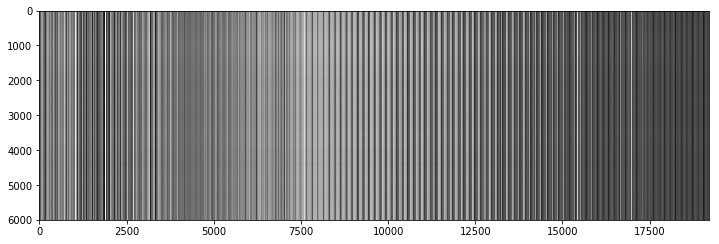

In [21]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')

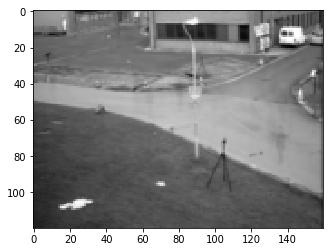

In [22]:
plt.imshow(np.reshape(low_rank[0, :], dims), cmap='gray');

How do we get the people from here?

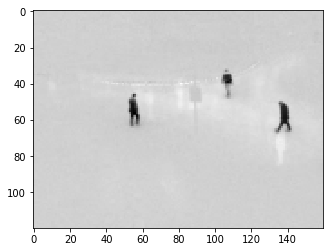

In [23]:
plt.imshow(np.reshape(M[0, :] - low_rank[0, :], dims), cmap='gray');

High-resolution version

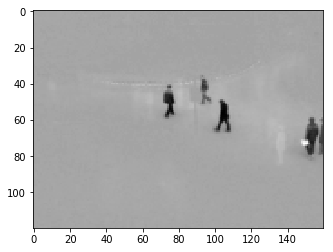

In [24]:
plt.imshow(np.reshape(M[140, :] - low_rank[140, :], dims), cmap='gray');

### 2 Backgrounds in 1 Video

We'll now use real video 008 dataset from [BMC 2012 Background Models Challenge Dataset](http://bmc.iut-auvergne.com/?page_id=24), in addition to video 003 that we used above.

In [25]:
from moviepy.editor import concatenate_videoclips

In [26]:
video2 = mpe.VideoFileClip("movie/Video_008.avi")

In [27]:
concat_video = concatenate_videoclips([video2.subclip(0,20), video.subclip(0,10)])
concat_video.write_videofile("movie/concatenated_video.mp4")

[MoviePy] >>>> Building video movie/concatenated_video.mp4
[MoviePy] Writing video movie/concatenated_video.mp4


100%|██████████████████████████████████████▊| 300/301 [00:00<00:00, 544.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/concatenated_video.mp4 



In [28]:
concat_video = mpe.VideoFileClip("movie/concatenated_video.mp4")

### Now back to our background removal problem:

In [29]:
concat_video.ipython_display(width=300, maxduration=160)

100%|█████████████████████████████████████▊| 300/301 [00:00<00:00, 1595.65it/s]


In [30]:
scale = 0.5   # Adjust scale to change resolution of image
dims = (int(240 * scale), int(320 * scale))

In [31]:
N = create_data_matrix_from_video(concat_video, fps, scale).T
# N = np.load("low_res_traffic_matrix.npy")

In [32]:
np.save("med_res_concat_video.npy", N)

In [33]:
N.shape

(1800, 19200)

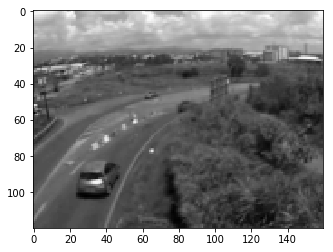

In [34]:
plt.imshow(np.reshape(N[200, :], dims), cmap='gray');

In [35]:
U_concat, s_concat, V_concat = np.linalg.svd(N, full_matrices=False)

This is slow, so you may want to save your result to use in the future.

In [36]:
np.save("movie/U_concat.npy", U_concat)
np.save("movie/s_concat.npy", s_concat)
np.save("movie/V_concat.npy", V_concat)

In the future, you can just load what you've saved:

In [37]:
U_concat = np.load("movie/U_concat.npy")
s_concat = np.load("movie/s_concat.npy")
V_concat = np.load("movie/V_concat.npy")

In [38]:
low_rank = U_concat[:,:10] @ np.diag(s_concat[:10]) @ V_concat[:10,:]

The top few components of U:

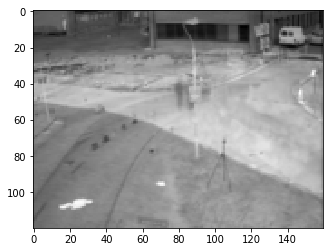

In [39]:
plt.imshow(np.reshape(V_concat[1, :], dims), cmap='gray')

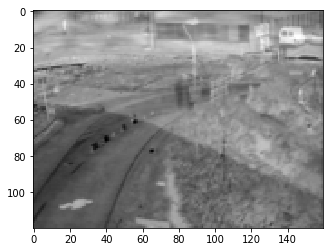

In [40]:
plt.imshow(np.reshape(V_concat[2, :], dims), cmap='gray')

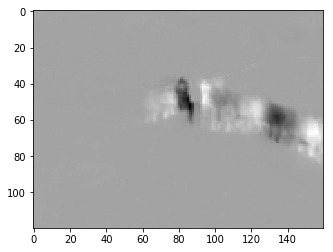

In [41]:
plt.imshow(np.reshape(V_concat[3, :], dims), cmap='gray')

Background removal:

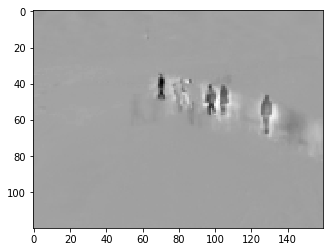

In [42]:
plt.imshow(np.reshape((N - low_rank)[-40, :], dims), cmap='gray')

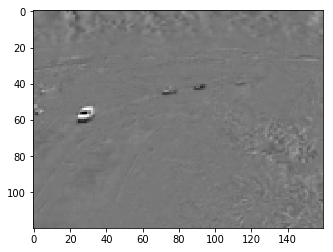

In [43]:
plt.imshow(np.reshape((N - low_rank)[240, :], dims), cmap='gray')

### Aside about data compression

Suppose we take 700 singular values (remember, there are 10000 singular values total)

In [44]:
s[0:1000:50]

array([1341719.6552,   10527.5148,    6162.0638,    4234.9367,
          3174.0389,    2548.4273,    2138.1887,    1812.9873,
          1557.7163,    1345.805 ,    1163.2866,    1000.5186,
           841.4604,     665.7271,       0.    ,       0.    ,
             0.    ,       0.    ,       0.    ,       0.    ])

In [45]:
k = 700
compressed_M = U[:,:k] @ np.diag(s[:k]) @ V[:k,:]

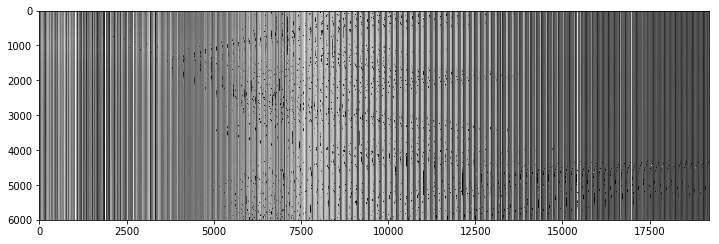

In [46]:
plt.figure(figsize=(12, 12))
plt.imshow(compressed_M, cmap='gray')

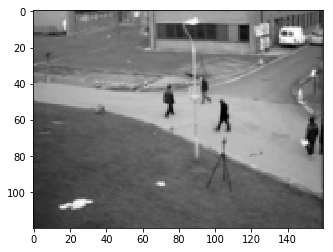

In [47]:
plt.imshow(np.reshape(compressed_M[140, :], dims), cmap='gray');

In [48]:
np.allclose(compressed_M, M)

True

In [49]:
np.linalg.norm(M - compressed_M)

4.902913878234673e-09

In [50]:
U[:,:k].shape, s[:k].shape, V[:k,:].shape

((6000, 700), (700,), (700, 19200))

space saved = data in U, s, V for 700 singular values / original matrix

In [51]:
((19200 + 1 + 6000) * 700) / (19200 * 6000)

0.1531310763888889

We only need to store 15.3% as much data and can keep the accuracy to 1e-5!  That's great!

### That's pretty neat!!! but...

The runtime complexity for SVD is $\mathcal{O}(\text{min}(m^2 n,\; m n^2))$

**Downside: this was really slow (also, we threw away a lot of our calculation)**

In [ ]:
%time u, s, v = np.linalg.svd(M, full_matrices=False)